In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector=inspect(engine)
# Use Inspector to print the column names and types
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

Text(0.5, 1.0, 'Precipitation & Dates')

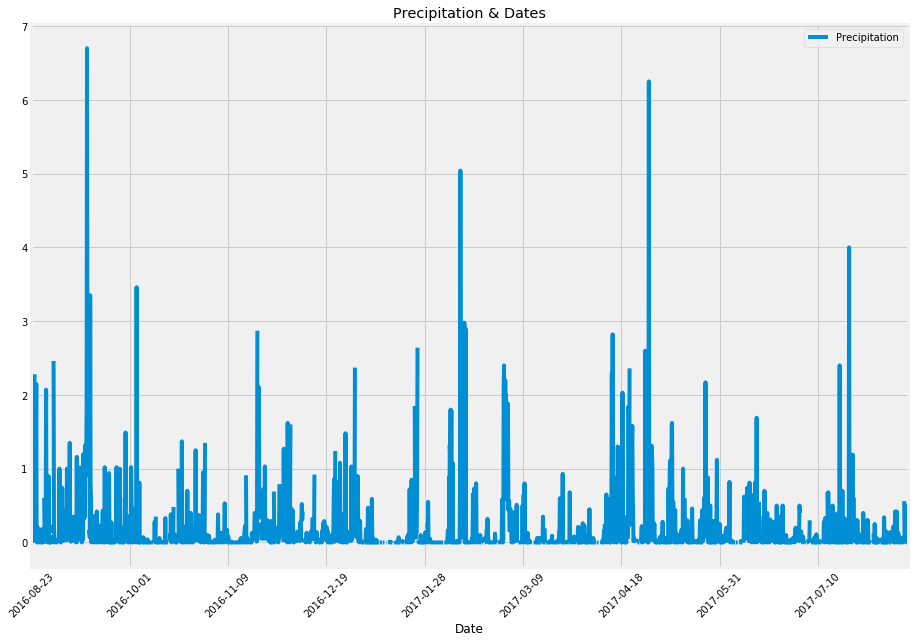

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#date = dt.datetime(2016, 8, 23) #set our start date to get the last 12 months of data

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
start_date = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
lab = [Measurement.date.label('Date'),
       Measurement.prcp.label("Precipitation")] 
       
prec_lastyear = session.query(*lab).filter(Measurement.date >= start_date).all()
       
# Save the query results as a Pandas DataFrame and set the index to the date column
df_prec = pd.DataFrame(prec_lastyear).set_index('Date')

# Sort the dataframe by date
df_prec = df_prec.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data

df_prec.plot(figsize=(14,10),rot=45)
plt.title('Precipitation & Dates')



In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prec.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count()
station_count

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stat = [Station.id,
       Station.name,
       Measurement.station,
       func.count(Measurement.id).label('Count')]
grouped_stat = session.query(*active_stat).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
grouped_stat

[(7, 'WAIHEE 837.5, HI US', 'USC00519281', 2772),
 (1, 'WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 (2, 'KANEOHE 838.1, HI US', 'USC00513117', 2709),
 (6, 'WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 (9, 'MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 (3, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 2202),
 (8, 'HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 (4, 'PEARL CITY, HI US', 'USC00517948', 1372),
 (5, 'UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Station.id,
       Measurement.station,
       func.min(Measurement.prcp),
       func.avg(Measurement.prcp),
       func.max(Measurement.prcp)]
stat_active = session.query(*sel).filter(Measurement.station == Station.station, Station.id == stats[0][0]).group_by(Measurement.station).all()
stat_active       

NameError: name 'stats' is not defined

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_stat = [Measurement.date.label('Date'),
       Measurement.tobs.label("Temperature")] 
       
temp_station = session.query(*high_stat).filter(Measurement.date >= start_date, Measurement.station == stats[0][2]).all()

station_df = pd.DataFrame(temp_station).set_index('Date')

station_df.plot.hist(figsize=(10,5),bins=12)

plt.title("Temperature by station")


NameError: name 'stats' is not defined

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2011-01-03', '2011-01-10'))

[(58.0, 67.46153846153847, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2011-01-03'
trip_end = '2011-01-10'

trip_data = calc_temps(trip_start, trip_end)
print(trip_data)

[(58.0, 67.46153846153847, 74.0)]


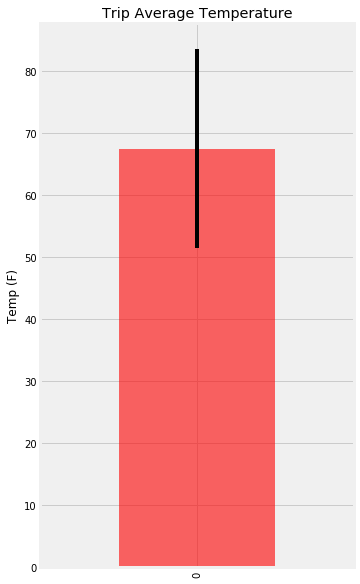

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


trip_df = pd.DataFrame(trip_data,columns=['Min','Avg','Max'])
y = trip_df['Max'] - trip_df['Min']

trip_df['Avg'].plot(kind='bar',yerr=y, figsize=(5,10),grid=True, color='red', alpha=0.6)
plt.title("Trip Average Temperature")
plt.ylabel("Temp (F)")
title = 'Trip Avg Temp'



In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

sel = [Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation
       ] 
       
prec_lastyear = session.query(*sel,func.sum(Measurement.prcp).label("Precipitation"))\
                                .filter(Measurement.station == Station.station)\
                                .filter(Measurement.date >= trip_start)\
                                .filter(Measurement.date <= trip_end)\
                                .group_by(*sel)\
                                .order_by(func.sum(Measurement.prcp).desc()).all()
prec_lastyear

[('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.71),
 ('WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.32000000000000006),
 ('KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29000000000000004),
 ('UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  0.29000000000000004),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.25),
 ('WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.16999999999999998),
 ('PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.02),
 ('WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.01),
 ('HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0)]